In [1]:
import os, re
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

# Linearity

In [2]:
def load_single_linear(path):
    # prior on the name
    start = '_'
    end = '.txt'
    
    last = len(path)-path[::-1].find(start)
    v_true = path[last:path.find(end)]
    
    with open(path) as f:
        lines = f.readlines()[1:]    
        v = np.zeros((len(lines), 1))
    
        for i, l in enumerate(lines):
            v[i] = float(l)/65535
    
        return v, float(v_true)

def load_all_linear(path):
    v_list = []
    v_true_list = []
    f_list = [f for f in os.listdir(path) if f.endswith('.txt')]
    
    if path.endswith(os.path.sep):
        new_path = path
    else:
        new_path = path+os.path.sep
    
    for f in f_list:
        v, v_true = load_single_linear(new_path+f)
        
        v_list.append(v)
        v_true_list.append(v_true)
        
    return v_list, v_true_list

def get_color(ind):
    colors = ['#0072BD', '#D95319','#EDB120','#7E2F8E','#77AC30','#4DBEEE','#A2142F']
    return colors[ind%len(colors)]

In [3]:
# import data
root = 'data/AI/linearity/'
v_all, v_true_all = load_all_linear(root)

In [4]:
v_mean = np.zeros((len(v_all),))
v_std = np.zeros((len(v_all),))
for i, vals in enumerate(v_all):
    v_mean[i] = np.mean(vals)
    v_std[i] = np.std(vals)

    
s_x = 'applied voltage (V)'
s_y = 'mean measurement (a.u.)'
s_std = 'Std'
df = pd.DataFrame({s_x: v_true_all, s_y: v_mean, s_std: v_std})
print(df)

   applied voltage (V)  mean measurement (a.u.)       Std
0                  0.8                 0.803162  0.000612
1                  0.9                 0.903037  0.000548
2                  0.7                 0.703792  0.000383
3                  0.6                 0.603957  0.000451
4                  0.4                 0.404133  0.000392
5                  0.5                 0.504137  0.000422
6                  0.1                 0.104586  0.000363
7                  0.0                 0.002111  0.000358
8                  0.2                 0.204815  0.000360
9                  0.3                 0.304740  0.000401


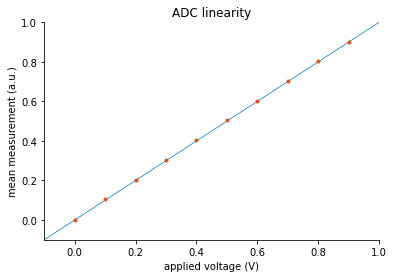

In [5]:
ax = plt.subplot(111)
plt.plot([-0.1, 1], [-0.1, 1], '-', color = get_color(0), linewidth = 0.7)
plt.plot(v_true_all, v_mean, '.', color = get_color(1))

plt.ylim([-0.1, 1])
plt.xlim([-0.1, 1])

plt.title('ADC linearity')
plt.xlabel(s_x)
plt.ylabel(s_y)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Signal read-out

In [6]:
def load_single(path):
    
    with open(path) as f:
        lines = f.readlines()[1:]
        v = np.zeros((len(lines), 2))
    
        for i, l in enumerate(lines):
            split = l.split('\t')
            v[i,0] = float(split[0])
            v[i,1] = float(split[1])/65535
    
        return v

In [7]:
# import data
file = 'data/AI/sinusoid/6.5Hz_0.8V.txt'
v = load_single(file)
print(v.shape)

(200, 2)


In [8]:
mean_dt = np.mean(v[1:,0]-v[:-1,0])
std_dt = np.std(v[1:,0]-v[:-1,0])
print(f'Mean difference between time points: {mean_dt} +/- {std_dt}s  \n(sampling = {1/mean_dt} Hz).')

Mean difference between time points: 0.015984947357944503 +/- 0.004907686697759833s  
(sampling = 62.55885475299992 Hz).


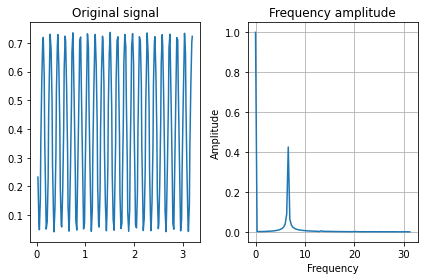

Experimental frequency is f = 6.319076237676759


In [9]:
# Fourier analysis (although sampling is not exactly uniform)
fs = 1/mean_dt # average sampling rate
t = v[:,0]
y = v[:,1]

fig, ax = plt.subplots(1, 2)
ax[0].plot(t, y)
ax[0].set_title("Original signal")

y_fft = np.fft.fft(y)           
y_fft = np.abs(y_fft[:round(len(t)/2)]) # positve freqs only
y_fft = y_fft/max(y_fft)     

freq_x_axis = np.linspace(0, fs/2, len(y_fft))

ax[1].plot(freq_x_axis, y_fft, "-")
ax[1].set_title("Frequency amplitude")
ax[1].set_xlabel("Frequency")
ax[1].set_ylabel("Amplitude")
plt.grid()
plt.tight_layout()
plt.show()

f_ind = np.argmax(y_fft[1:]) # Finds the index of the max != 0
f_exp = freq_x_axis[f_ind] 
print(f"Experimental frequency is f = {f_exp}")

In [10]:
from scipy.optimize import curve_fit

# Theoretical signal
min_x = np.min(v[:,1])
max_x = np.max(v[:,1])
print(f'Min-Max difference: {max_x-min_x} V.')
amplitude = (max_x-min_x)/2

f_th = 6.5
t_sub = np.array([t[0]-0.01+i*(2.02-t[0])/10000 for i in range(10000) ])

def th_signal(t, ph):
    return amplitude * (1 + np.sin( 2*np.pi*f_th * ( t+ph ) ) ) + min_x

# fit curve to experimental signal to 
ph_fit, _ = curve_fit(th_signal,t,y)

signal = th_signal(t_sub, ph_fit)

Min-Max difference: 0.6949721522850386 V.


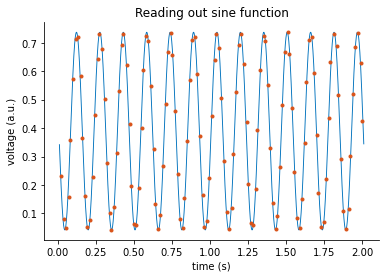

In [12]:
# Plot
ax = plt.subplot(111)

tmax = int(2 / mean_dt)

plt.plot(t_sub, signal, '-', color = get_color(0), linewidth = 0.9)
plt.plot(t[:tmax], y[:tmax], '.', color = get_color(1))

plt.title('Reading out sine function')
plt.xlabel('time (s)')
plt.ylabel('voltage (a.u.)')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)